### ETAのシミュレーション
自動運転車が道路を走る際、

Strategic（運行前計画） => Tactical（運行時の計画） => Ground（細かいセンシングなど）

の3つのフェーズがある。本研究では2つ目のTacticalフェーズにおける、車両の間隔制御を目的とする。まず、Strategicフェーズでは、だいたい何時頃に何台が到着するかがわかる。それを受けてTacticalフェーズでは実際に道路に到着した車に走路の事前予約（以下、CWP Reservation）を行わせ、その通りに運行する。このシミュレーションはCWP Reservationのアルゴリズムについての研究である。

ここでは大きく3つのオブジェクトが登場する

1. CWPTable: 予約管理をするテーブル
2. Car: 到着時刻に基づきCWPTableに希望時刻を打刻する。
3. Simulation: 帯域密度や到着間隔の管理を行う。

In [17]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list

### パラメータ

- Global Density: 大域密度. 単位時間あたりの流入量
- Total_time_window: チケットを売っている時間の合計秒数
- window_size: チケット販売を分割する際の時間窓
- partition_num: チケット販売の分割数. 1だったら分割なしということ。

  ```Total_time_window = window_size * partition_num```
  が成立する。

In [53]:
# 初期設定（独立変数群）
CAR_NUM = 10 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 60  # Strategic Phaseでの時間幅
BATCH_NUM = 1
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 5 # 目標とする車間時間 [s]
DESIRED_SPEED = 25 # 目標とする車間時間 [s]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }
rss_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, 
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":True,
  }
    

In [54]:
# 従属的に決まるもの
SIMULATION_STEPS = int(TOTAL_TIME / TIME_STEP)
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])

CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]

In [64]:
# ETA割り当てのアルゴリズム
"""
KISS: 基本的には車のdesiredに合わせる、最初のWaypointからTTCの分だけ空ける
CONTROLLED: 全体最適になるように調整
"""
ALGORITHM_LIST = ["KISS", "CONTROLLED", ]
ALGORITHM = ALGORITHM_LIST[1]

cwp_table = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM, \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

cwp_table_kiss = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM_LIST[0], \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

60.0
60.0


In [65]:
# 一旦雑にsimulation開始

for i in range(SIMULATION_STEPS):
    t = i * TIME_STEP
    delta_x_list = find_delta_x_list(CARS)
    delta_v_list = find_delta_v_list(CARS)

    for idx, car in enumerate(CARS):
        # この時間に到着する車がいれば打刻する
        if car.arrival_time >= t and car.arrival_time < t + TIME_STEP:
            print("idx={0}, 到着時刻={1}".format(idx, car.arrival_time))
            desired_list = car.create_desired_list(WAYPOINTS)
            # print(desired_list)
            is_valid = cwp_table.validate(desired_list)
            if is_valid:
                cwp_table.register(desired_list)
            else:
                calibration_info = {"desired_list":desired_list, "enter_speed": car.mean_speed, \
                                   "max_acc": car.helly_params["max_accel"],  "max_dec": car.helly_params["rear_brake_acc"]}
                calibrated_list, speed_profile = cwp_table.calibrate_list(**calibration_info)
                # print(calibrated_list)
                cwp_table.register(calibrated_list)
                car.speed_profile = speed_profile
            continue
        
        # そうでない車は普通に進む
        # delta_x = delta_x_list[idx]
        # delta_v = delta_v_list[idx]
        # speed = car.decide_speed(TIME_STEP, delta_x, delta_v)
        # print("idx:",idx, " speed:",speed)
        # print(delta_x_list)
        # print(delta_v_list)

        # delta_xとdelta_vの計算を移動前にやっているので実質pararellになっている
        # car.proceed(time_step=TIME_STEP)
        # car.record()
            
                


idx=0, 到着時刻=12.334741286447686
control
理想到着時刻 40.0
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 950.3603485420924
ACDでも不可能

出口到達時刻:  42.17477125957529
idx=1, 到着時刻=15.120627286515571
control
理想到着時刻 45.0
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 1038.9249085393772
CAC_MAX=740.73, course_length=1000.00
PROFILE:  ACD
m1の解=8.59
距離:999.93

出口到達時刻:  45.002792305023085
idx=2, 到着時刻=16.137828862049837
control
理想到着時刻 50.0
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 1198.2368455180065
CAC_MAX=840.30, course_length=1000.00
PROFILE:  ACD
m1の解=5.29
距離:999.76

出口到達時刻:  50.00943616260838
idx=3, 到着時刻=21.666757185274697
control
理想到着時刻 55.0
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 1177.0797125890122
CAC_MAX=827.08, course_length=1000.00
PROFILE:  ACD
m1の解=5.61
距離:999.66

出口到達時刻:  55.013723008421984
idx=4, 到着時刻=23.917497147338327
control
理想到着時刻 60.0
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 1287.050114106467
CAC_MAX=895.81, course_length=1000.00
PROFILE:  ACD
m1の解=4.13
距離:1000.18

出口到達

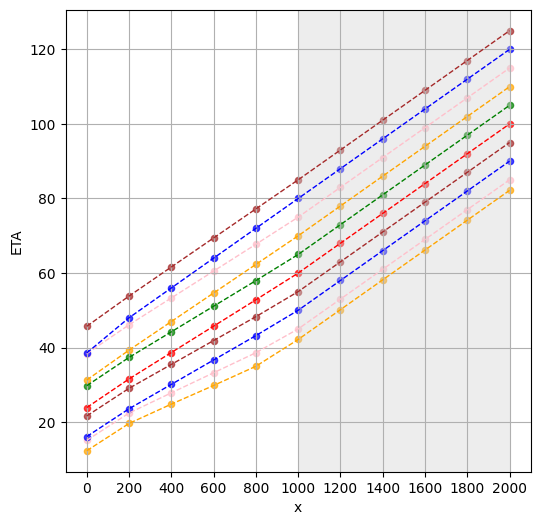

In [66]:
cwp_table.plot()

None


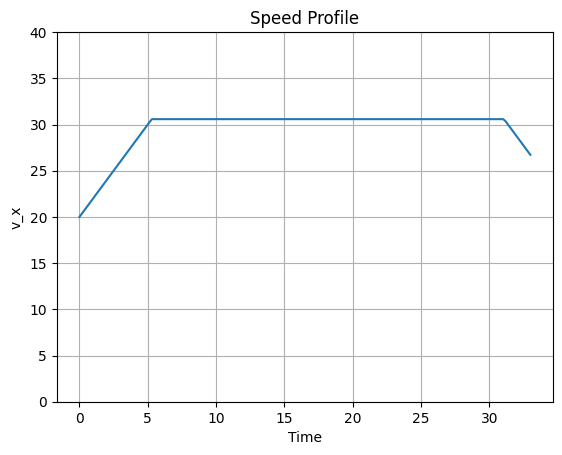

In [69]:
print(CARS[2].plot_speed_profile())

In [5]:
df = cwp_table.waypoint_table
print(df[df['car_idx'] == 0])
print(df[df['car_idx'] == 1])
print(CARS[1].arrival_time)

    waypoint_idx       x        eta  car_idx  group_id  order_in_group
0              0     0.0   1.904061        0         0               0
1              1   200.0   9.843090        0         0               0
2              2   400.0  17.379429        0         0               0
3              3   600.0  24.915767        0         0               0
4              4   800.0  32.452106        0         0               0
5              5  1000.0  40.011396        0         0               0
6              6  1200.0  48.011396        0         0               0
7              7  1400.0  56.011396        0         0               0
8              8  1600.0  64.011396        0         0               0
9              9  1800.0  72.011396        0         0               0
10            10  2000.0  80.011396        0         0               0
    waypoint_idx       x        eta  car_idx  group_id  order_in_group
0              0     0.0   3.299702        1         0               1
1     

In [71]:
cwp_table_controlled = cwp_table

In [75]:
cwp_table_kiss = cwp_table


In [8]:
cwp_table.waypoint_table

,waypoint_idx,x,eta,car_idx,group_id,order_in_group
0,0,0.0,7.906738,0,0,0
1,1,200.0,15.248834,0,0,0
2,2,400.0,21.317882,0,0,0
3,3,600.0,27.386929,0,0,0
4,4,800.0,33.455976,0,0,0
5,5,1000.0,40.006582,0,0,0
6,6,1200.0,48.006582,0,0,0
7,7,1400.0,56.006582,0,0,0
8,8,1600.0,64.006582,0,0,0
9,9,1800.0,72.006582,0,0,0


In [7]:
a = None
a[0]

TypeError: 'NoneType' object is not subscriptable